#1. Set up


In [ ]:
!pip install SentencePiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.0 MB/s eta 0:00:00


In [ ]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.4 MB/s eta 0:00:00


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 12.8 MB/s eta 0:00:00


#2 Import libary

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from transformers import AdamW, set_seed
import matplotlib.pyplot as plt
from accelerate import Accelerator
from tqdm.notebook import tqdm
import datasets
import transformers
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#3 Dataset

In [ ]:
filename = "/content/drive/MyDrive/52000820 - Deep learning/Cuoi Ki - DL Application/vietnamese_summary_dataset.csv"
df = pd.read_csv(filename, error_bad_lines=False, encoding='utf-8',engine="python")


<ipython-input-6-4ffa49145beb>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(filename, error_bad_lines=False, encoding='utf-8',engine="python")


In [ ]:
df.head(5)

,document,summary
0,Hoa quả và rau thường rẻ hơn khi vào mùa. Thườ...,Chọn rau quả đúng mùa. Xem giá trên các sản ph...
1,Không phải tất cả các nguyên liệu lành mạnh đề...,Chọn các nguyên liệu rẻ hơn. Giảm protein tron...
2,Thường thì bạn có thể tận dụng một khoảnh vườn...,Trồng những loại rau bạn có thể trồng được. Tự...
3,Việc lập thực đơn sẽ giúp bạn chỉ mua những th...,Quyết định các bữa ăn chính trong tuần. Chọn n...
4,Đây là cách nhanh nhất để truy cập thiết lập m...,"Nhấp phải vào màn hình của bạn. Chọn ""Screen r..."


In [ ]:
df.shape

(19581, 2)

<Axes: >

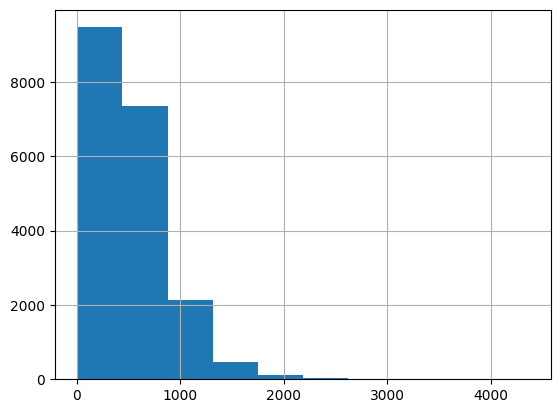

In [ ]:
def wl(text):
    return len(text.split(" "))
df['word_length']=df['document'].apply(wl)
df['word_length'].hist()



<Axes: >

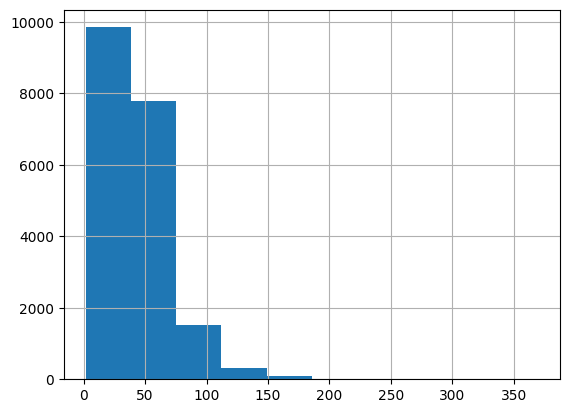

In [ ]:
df['word_length']=df['summary'].apply(wl)
df['word_length'].hist()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df["document"].values, df["summary"].values, random_state=0, train_size = .95)

In [ ]:
print(X_train.shape, X_val.shape)

(18601,) (980,)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("minhtoan/t5-small-wikilingua_vietnamese")

In [ ]:
import string
import re
def preprocess(text):
  text = text.lower()
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  html_pattern = re.compile('<.*?>')
  text =  html_pattern.sub(r'', text)
  text = url_pattern.sub(r'', text)
  PUNCT_TO_REMOVE = string.punctuation
  text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text =  emoji_pattern.sub(r'', text)
  text = text.replace("!@#$%^&*()[]{};:,./<>?\|`~=_+”\"“”'“","")
  return text.strip()
print(preprocess('<h1> @@ 🔥🔥 https://www.h2o.ai/blog/detecting-sarcasm-is-difficult-but-ai-may-have-an-answer/ "h"anh ấy </h1>.'))

hanh ấy


In [ ]:
prefix = "Summarize: "
max_input_length = 512
max_target_length = 52
def preprocess_examples(examples):
  # encode the documents
  articles = examples['document']
  summaries = examples['summary']

  inputs = [prefix + preprocess(article) for article in articles]
  model_inputs = tokenizer(inputs, max_length=max_input_length, padding="max_length", truncation=True)

  # encode the summaries
  labels = tokenizer(summaries, max_length=max_target_length, padding="max_length", truncation=True).input_ids

  # important: we need to replace the index of the padding tokens by -100
  # such that they are not taken into account by the CrossEntropyLoss
  labels_with_ignore_index = []
  for labels_example in labels:
    labels_example = [label if label != 0 else -100 for label in labels_example]
    labels_with_ignore_index.append(labels_example)

  model_inputs["labels"] = labels_with_ignore_index

  return model_inputs


In [ ]:
data_dict = {'document': X_train, 'summary': y_train}
train_ds = Dataset.from_dict(data_dict)

data_dict = {'document': X_val, 'summary': y_val}
val_ds = Dataset.from_dict(data_dict)

In [ ]:
encoded_train_ds = train_ds.map(preprocess_examples, batched=True, remove_columns=train_ds.column_names)
encoded_val_ds = val_ds.map(preprocess_examples, batched=True, remove_columns=val_ds.column_names)

Map:   0%|          | 0/18601 [00:00<?, ? examples/s]

Map:   0%|          | 0/980 [00:00<?, ? examples/s]

In [ ]:
train_ds

Dataset({
    features: ['document', 'summary'],
    num_rows: 18601
})

In [ ]:
example = train_ds[0]
document= example['document']
summary = example['summary']
print("Document:", document)
print("Summary:", summary)

Document: Mục đích của thông tin phản hồi là để giúp học sinh học tập, vì thế hãy đưa ra bình luận có ích mà hướng dẫn họ cải thiện công việc thay vì phê bình lỗi. Hãy xem nó như hướng dẫn và không chỉ phê bình. Bạn có thể đưa ra phản hồi bằng văn bản về các dạng bài tập của học sinh, bao gồm bài tập làm văn, bài thuyết trình, và dự án. Cả hai phần đều quan trọng, và học sinh cần biết cách cải thiện chúng. Điều này đặc biết cần thiết nếu một học sinh làm tốt phần này hơn phần khác. Ví dụ, một học sinh có thể có ý tưởng xuất sắc về phát triển nội dung, trong khi vẫn còn lỗi chính tả, phép chấm câu sai, thừa đoạn chưa hoàn chỉnh và lỗi không thụt đầu dòng.  Nếu bạn đang nhận xét về bài thuyết trình miệng hoặc dự án, đảm bảo cung cấp thông tin phản hồi về mỗi phần của bài tập. Ví dụ, một bài thuyết trình miệng sẽ bao gồm nhận xét về cả nội dung lẫn kỹ năng nói chuyện trước đám đông, trong khi một dự án có thể nhận được thông tin phản hồi về nội dung, tính sáng tạo, và kỹ năng trình bày. V

In [ ]:
tokenizer.decode(encoded_train_ds[1]['input_ids'])

'Summarize: tập thể dục kết hợp chế độ ăn ít calo sẽ hỗ trợ và tăng tốc độ giảm cân bằng cách đốt cháy calo và tăng cường trao đổi chất sự kết hợp bài tập cơ tim thường xuyên sẽ giúp bạn giảm cân và giảm cả mỡ bụng chạy bộ leo núi đạp xe và bơi lội là những bài tập cardio giúp đốt cháy calo bạn nên tập bài tập tăng cường sức khỏe timphổi ít nhất 30 phút 5 lần mỗi tuần để đạt hiệu quả tốt nhất nếu không muốn tập thể dục hàng ngày bạn cần tìm cách tăng cường hoạt động trong sinh hoạt hàng ngày ví dụ tập thói quen đi thang bộ thay cho thang máy đậu xe cách xa điểm đến dùng bàn làm việc đứng tập thể dục càng quan trọng hơn đối với nhân viên làm việc bàn giấy và ít vận động bạn càng lớn tuổi thì việc giảm mỡ bụng sẽ càng khó một phần là do hiện tượng giảm khối lượng cơ nạc tự nhiên khi bạn già đi nhưng cũng có thể là do cơ thể bắt đầu tích trữ thêm mỡ quanh bụng duy trì khối lượng cơ nạc có thể giúp ngăn ngừa hiện tượng này tập bài tập rèn luyện sức bền ít nhất 2 ngày mỗi tuần mỗi ngày 2030

In [ ]:
labels = encoded_train_ds[0]['labels']
print(labels)

[366, 2627, 259, 12046, 259, 793, 268, 300, 3452, 297, 2906, 297, 260, 371, 1485, 317, 1345, 325, 394, 1735, 3147, 690, 1629, 382, 2434, 266, 300, 1492, 259, 272, 2291, 17795, 259, 793, 317, 1345, 273, 28182, 297, 260, 977, 2294, 262, 1101, 394, 1735, 3147, 690, 1629, 382, 2434, 1]


In [ ]:
encoded_train_ds.set_format(type="torch")
encoded_val_ds.set_format(type="torch")

In [ ]:
print("Number of training examples:", len(encoded_train_ds))
print("Number of validation examples:", len(encoded_val_ds))

Number of training examples: 18601
Number of validation examples: 980


In [ ]:
from torch.utils.data import DataLoader

def create_dataloaders(train_batch_size=8, eval_batch_size=8):
    train_dataloader = DataLoader(encoded_train_ds, shuffle=True, batch_size=train_batch_size)
    val_dataloader = DataLoader(encoded_val_ds, shuffle=False, batch_size=eval_batch_size)

    return train_dataloader, val_dataloader

#**Training**

In [ ]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 1, # set to very high number
    "train_batch_size": 4, # Actual batch size will this x 8 (was 8 before but can cause OOM)
    "eval_batch_size": 8, # Actual batch size will this x 8 (was 32 before but can cause OOM)
    "seed": 42,
    "patience": 3, # early stopping
    "output_dir": "/content/drive/MyDrive/52000820 - Deep learning/Cuoi Ki - DL Application/model_deploy_T5_1epoch",
}

In [ ]:
def training_function():
    # Initialize accelerator
    accelerator = Accelerator()

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Instantiate the model, let Accelerate handle the device placement.
    model = AutoModelForSeq2SeqLM.from_pretrained("minhtoan/t5-small-wikilingua_vietnamese")


    # Instantiate optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters["learning_rate"])

    # Prepare everything
    train_dataloader, val_dataloader = create_dataloaders(
        train_batch_size=hyperparameters["train_batch_size"], eval_batch_size=hyperparameters["eval_batch_size"]
    )
    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(model, optimizer,
                                                                             train_dataloader, val_dataloader)

    # Now we train the model
    epochs_no_improve = 0
    min_val_loss = 1000000
    for epoch in range(hyperparameters["num_epochs"]):
        # We only enable the progress bar on the main process to avoid having 8 progress bars.
        progress_bar = tqdm(range(len(train_dataloader)), disable=not accelerator.is_main_process)
        progress_bar.set_description(f"Epoch: {epoch}")
        model.train()
        for batch in train_dataloader:
            outputs = model(**batch)
            loss = outputs.loss
            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()
            progress_bar.set_postfix({'loss': loss.item()})
            progress_bar.update(1)

        # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
        model.eval()
        val_losses = []
        validation_losses = []
        for batch in val_dataloader:
            with torch.no_grad():
                outputs = model(**batch)
            loss = outputs.loss
            # We gather the loss from the 8 TPU cores to have them all.
            validation_losses.append(accelerator.gather(loss[None]))

        # Compute average validation loss
        val_loss = torch.stack(validation_losses).sum().item() / len(validation_losses)
        val_losses.append(val_loss)
        # Use accelerator.print to print only on the main process.
        accelerator.print(f"epoch {epoch}: validation loss:", val_loss)
        if val_loss < min_val_loss:
          epochs_no_improve = 0
          min_val_loss = val_loss
          continue
        else:
          epochs_no_improve += 1
          # Check early stopping condition
          if epochs_no_improve == hyperparameters["patience"]:
            accelerator.print("Early stopping!")
            break

    # save trained model
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    # Use accelerator.save to save
    unwrapped_model.save_pretrained(hyperparameters["output_dir"], save_function=accelerator.save)


In [ ]:
from accelerate import notebook_launcher
notebook_launcher(training_function)

Launching training on one CPU.


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--minhtoan--t5-small-wikilingua_vietnamese/snapshots/570f07444053bd966032a7d291153ac317c97696/config.json
Model config T5Config {
  "_name_or_path": "minhtoan/t5-small-wikilingua_vietnamese",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 1024,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 8,
  "num_heads": 6,
  "num_layers": 8,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "torch_dtype": "float32",
  "transformers_version": "4.29.1",
  "use_cache": true,
  "vocab_size":

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--minhtoan--t5-small-wikilingua_vietnamese/snapshots/570f07444053bd966032a7d291153ac317c97696/pytorch_model.bin
Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.29.1"
}

All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at minhtoan/t5-small-wikilingua_vietnamese.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5ForConditionalGeneration for predictions without further training.
Generation config file not found, using a generation config created from the model config.


  0%|          | 0/4651 [00:00<?, ?it/s]

#**Predict**

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [ ]:
#text = train_ds[0]["document"]
import transformers
tokenizer = AutoTokenizer.from_pretrained("minhtoan/t5-small-wikilingua_vietnamese")
text = "Theo quy định, những người được mua nhà xã hội gồm: người có công với cách mạng; hộ gia đình nghèo, cận nghèo ở nông thôn và đô thị; người thu nhập thấp tại đô thị; lao động tại khu công nghiệp; sĩ quan, quân nhân, công nhân thuộc đơn vị công an, quân đội; hộ gia đình, cá nhân thuộc diện thu hồi đất mà chưa được bồi thường."

transformers.logging.set_verbosity(transformers.logging.ERROR)
trained_model = T5ForConditionalGeneration.from_pretrained(hyperparameters["output_dir"])

input_ids = tokenizer(preprocess(text), return_tensors="pt").input_ids

generated_ids = trained_model.generate(input_ids, do_sample=True,
    max_length=len(text),
    top_k=0,
    temperature=0.7
)

summary = tokenizer.decode(generated_ids.squeeze(), skip_special_tokens=True)
print(text)
print("summary: ",summary)